In [113]:
import yfinance as yf
import pywt
import matplotlib.pyplot as plt
import seaborn
seaborn.set_theme()
# Define the ticker symbol for Santiago Stock Exchange
ticker = "CONCHATORO.SN"

# Fetch historical data (e.g., for the last 5 years)
# You can also use specific dates: start="2020-01-01", end="2023-12-31"
vapores_data = yf.download(ticker, period="7y")

# Display the first few rows
print(vapores_data.head())


[*********************100%***********************]  1 of 1 completed

Price              Close          High           Low          Open  \
Ticker     CONCHATORO.SN CONCHATORO.SN CONCHATORO.SN CONCHATORO.SN   
Date                                                                 
2019-01-09   1113.389648   1115.789195   1096.592822   1103.791462   
2019-01-10   1115.708984   1119.708228   1095.952663   1119.708228   
2019-01-11   1114.429443   1119.708426   1097.472589   1119.708426   
2019-01-14   1119.788574   1119.788574   1119.788574   1119.788574   
2019-01-15   1119.388184   1126.986746   1107.790378   1118.028480   

Price             Volume  
Ticker     CONCHATORO.SN  
Date                      
2019-01-09        208305  
2019-01-10        161372  
2019-01-11         68284  
2019-01-14          9288  
2019-01-15         11814  


In [83]:
vapores_data.columns

MultiIndex([( 'Close', 'CONCHATORO.SN'),
            (  'High', 'CONCHATORO.SN'),
            (   'Low', 'CONCHATORO.SN'),
            (  'Open', 'CONCHATORO.SN'),
            ('Volume', 'CONCHATORO.SN')],
           names=['Price', 'Ticker'])

In [84]:
vap = vapores_data[["Close"]]

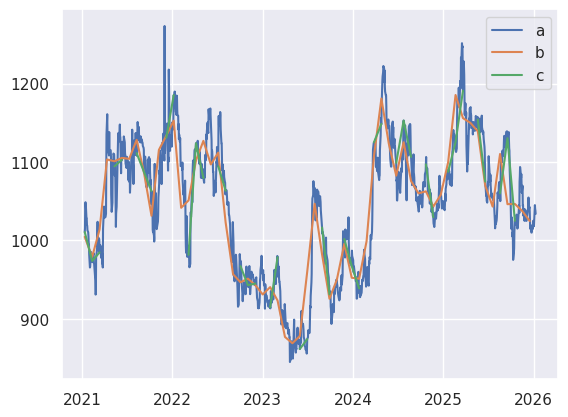

In [43]:
plt.plot(vapores_data["Close"])
plt.plot(vapores_data["Close"].resample("30D").mean())
plt.plot(vapores_data["Close"].asfreq("30D"))
plt.legend(["a", "b", "c"])

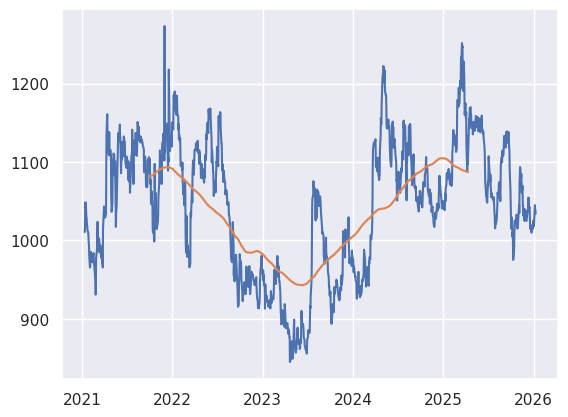

In [44]:
vapores_close_values = vapores_data["Close"].copy()
rolling = vapores_close_values.rolling(365, center=True)
plt.plot(vapores_close_values)
plt.plot(rolling.mean())

In [ ]:
import numpy as np
val = vap.values
val

Price,Close
Ticker,CONCHATORO.SN
Date,
2019-01-09,1113.389282
2019-01-10,1115.709106
2019-01-11,1114.429688
2019-01-14,1119.788574
2019-01-15,1119.388550
...,...
2026-01-05,1040.099976
2026-01-06,1045.000000


In [76]:
coef = pywt.wavedec(val, "db4", level=5)

In [77]:
type(coef[0])

numpy.ndarray

In [78]:
coef_clean = []
for idx, elem in enumerate(coef):
    if idx >0: coef_clean.append(np.array([0]*len(elem)))
    else: coef_clean.append(elem)


In [96]:
vap.Close.index

DatetimeIndex(['2019-01-09', '2019-01-10', '2019-01-11', '2019-01-14',
               '2019-01-15', '2019-01-16', '2019-01-17', '2019-01-18',
               '2019-01-21', '2019-01-22',
               ...
               '2025-12-24', '2025-12-26', '2025-12-29', '2025-12-30',
               '2026-01-02', '2026-01-05', '2026-01-06', '2026-01-07',
               '2026-01-08', '2026-01-09'],
              dtype='datetime64[ns]', name='Date', length=1743, freq=None)

In [104]:
import pandas as pd

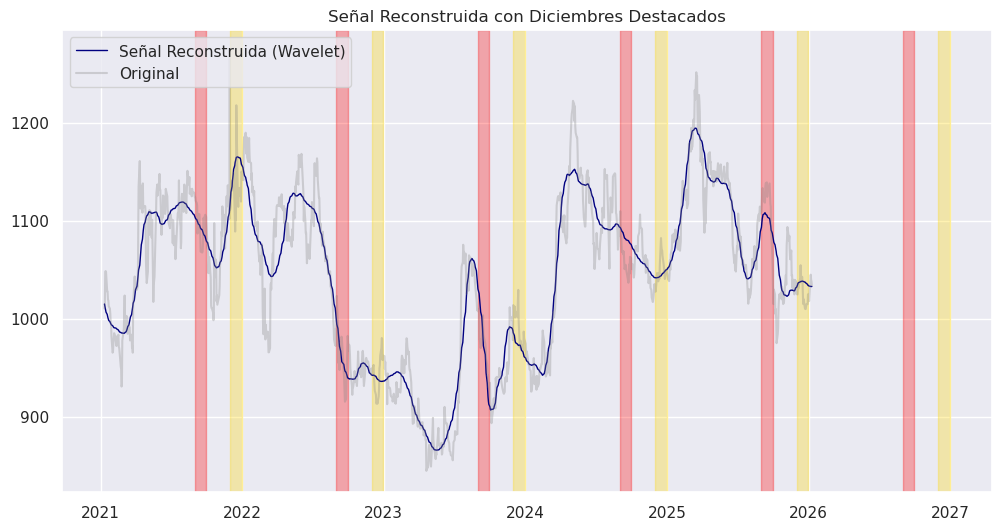

In [107]:
# 1. Obtener señal reconstruida
rec_signal = pywt.waverec(coef_clean, "db4")

# 2. Igualar largos: Cortamos la señal para que tenga el mismo tamaño que el índice original
# Esto evita el error "x and y must have same first dimension"
rec_signal = rec_signal[:len(vap.Close.index)]

# 1. Ajustar el índice para tomar solo los últimos 1244 registros
# para que coincida con tu señal 'rec_signal'
matched_index = vap.Close.index[-len(rec_signal):]
# 2. Configurar el gráfico
fig, ax = plt.subplots(figsize=(12, 6))

# 3. Graficar las líneas
ax.plot(matched_index, rec_signal, label='Señal Reconstruida (Wavelet)', color='navy', linewidth=1)
ax.plot(matched_index, vap.Close.values[-len(rec_signal):], label='Original', color='gray', alpha=0.3)

# 4. Bucle para resaltar los Diciembres
# Obtenemos los años únicos presentes en tus datos
unique_years = matched_index.year.unique()

for year in unique_years:
    # Definir inicio y fin de diciembre para ese año
    start_date = pd.Timestamp(f"{year}-12-01")
    end_date = pd.Timestamp(f"{year}-12-31")
    
    
    
    # Solo sombreamos si el rango cae dentro de nuestros datos visibles
    if start_date >= matched_index[0] or end_date <= matched_index[-1]:
        ax.axvspan(start_date, end_date, color='gold', alpha=0.3, label='_nolegend_')
    start_date = pd.Timestamp(f"{year}-09-01")
    end_date = pd.Timestamp(f"{year}-09-30")
    
    
    
    # Solo sombreamos si el rango cae dentro de nuestros datos visibles
    if start_date >= matched_index[0] or end_date <= matched_index[-1]:
        ax.axvspan(start_date, end_date, color='red', alpha=0.3, label='_nolegend_')

# Detalles finales
ax.set_title("Señal Reconstruida con Diciembres Destacados")
ax.legend(loc='upper left')
plt.show()

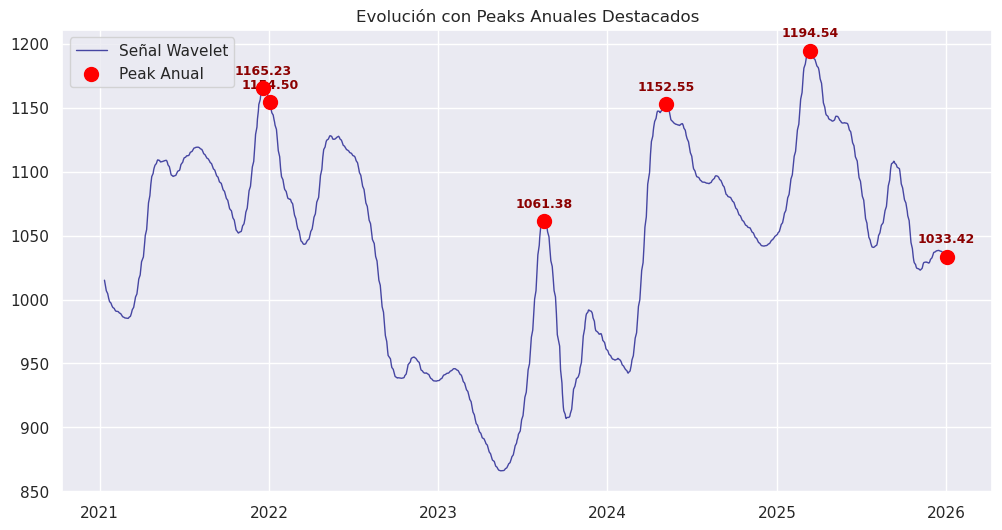

In [108]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Preparar los datos (Igual que antes)
matched_index = vap.Close.index[-len(rec_signal):]

# Creamos una Serie temporal temporal para facilitar el cálculo
# Esto nos permite usar el poder de Pandas para agrupar por año
serie_reconstruida = pd.Series(rec_signal, index=matched_index)

# 2. Encontrar los peaks por año
# idxmax() nos da la FECHA exacta del valor máximo
fechas_peaks = serie_reconstruida.groupby(serie_reconstruida.index.year).idxmax()
# Usamos esas fechas para obtener los VALORES exactos
valores_peaks = serie_reconstruida.loc[fechas_peaks]

# 3. Graficar
fig, ax = plt.subplots(figsize=(12, 6))

# Línea principal
ax.plot(matched_index, rec_signal, label='Señal Wavelet', color='navy', linewidth=1, alpha=0.7)

# Marcar los puntos (Scatter plot)
ax.scatter(fechas_peaks, valores_peaks, color='red', s=100, zorder=5, label='Peak Anual')

# 4. (Opcional) Agregar texto con el valor en cada punto
for fecha, valor in zip(fechas_peaks, valores_peaks):
    ax.annotate(f'{valor:.2f}',           # Texto a mostrar (formato 2 decimales)
                (fecha, valor),           # Coordenada del punto
                xytext=(0, 10),           # Desplazamiento del texto (10 pixeles arriba)
                textcoords='offset points',
                ha='center',              # Alineación horizontal
                fontsize=9,
                fontweight='bold',
                color='darkred')

ax.set_title("Evolución con Peaks Anuales Destacados")
ax.legend()
plt.show()

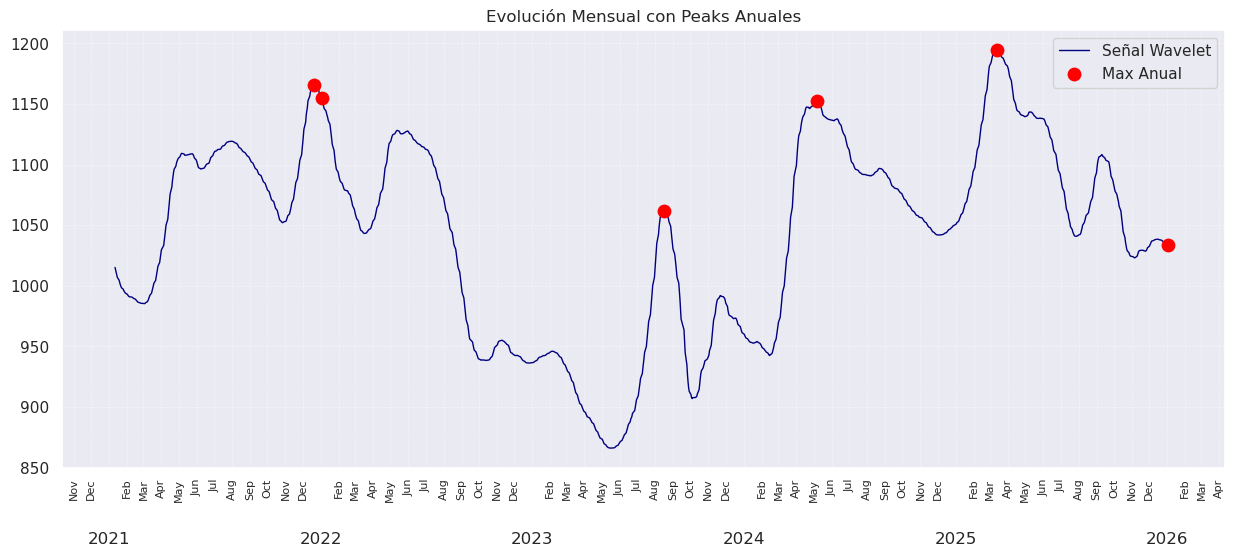

In [109]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # <--- Importante
import pandas as pd
import numpy as np

# --- 1. Preparar datos (Igual que antes) ---
matched_index = vap.Close.index[-len(rec_signal):]
serie_reconstruida = pd.Series(rec_signal, index=matched_index)

# Encontrar Peaks
fechas_peaks = serie_reconstruida.groupby(serie_reconstruida.index.year).idxmax()
valores_peaks = serie_reconstruida.loc[fechas_peaks]

# --- 2. Graficar ---
fig, ax = plt.subplots(figsize=(15, 6)) # Un poco más ancho para que quepan los meses

# Líneas y Puntos
ax.plot(matched_index, rec_signal, label='Señal Wavelet', color='navy', linewidth=1)
ax.scatter(fechas_peaks, valores_peaks, color='red', s=80, zorder=5, label='Max Anual')

# --- 3. CONFIGURACIÓN DEL EJE X (Los Meses) ---

# A. Configurar los AÑOS (Marcas grandes)
ax.xaxis.set_major_locator(mdates.YearLocator()) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y')) # \n para bajar el año y separarlo de los meses

# B. Configurar los MESES (Marcas chicas)
# 'interval=1' muestra todos los meses. Si se ve muy lleno, cambia a 2 o 3.
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1)) 
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b')) # %b = Ene, Feb, Mar (abreviado)

# C. Estilizar para que se lea bien
ax.tick_params(axis='x', which='minor', labelsize=8, rotation=90) # Rotar meses 90 grados
ax.tick_params(axis='x', which='major', labelsize=12, pad=15)     # Años más grandes y centrados

# Agregar una grilla suave para guiar el ojo
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Títulos
ax.set_title("Evolución Mensual con Peaks Anuales")
ax.legend()

# Ajustar márgenes para que no se corten las etiquetas de abajo
plt.subplots_adjust(bottom=0.15) 

plt.show()

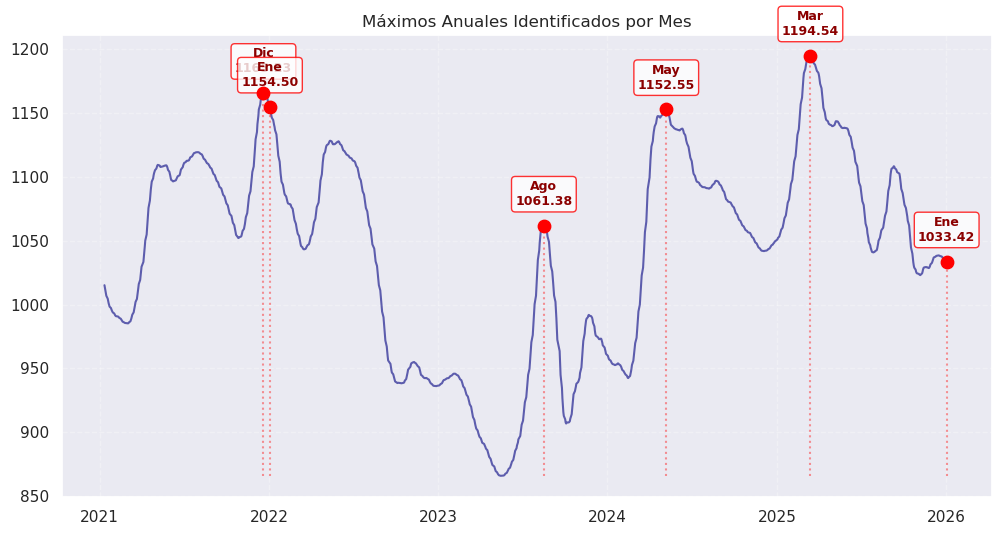

In [110]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. Preparar datos ---
matched_index = vap.Close.index[-len(rec_signal):]
serie_reconstruida = pd.Series(rec_signal, index=matched_index)

# Encontrar Peaks (Fecha y Valor)
fechas_peaks = serie_reconstruida.groupby(serie_reconstruida.index.year).idxmax()
valores_peaks = serie_reconstruida.loc[fechas_peaks]

# Diccionario para traducir meses a Español (opcional, por si tu PC está en inglés)
meses_esp = {
    1: 'Ene', 2: 'Feb', 3: 'Mar', 4: 'Abr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dic'
}

# --- 2. Graficar ---
fig, ax = plt.subplots(figsize=(12, 6))

# Línea base
ax.plot(matched_index, rec_signal, label='Señal Wavelet', color='navy', alpha=0.6)

# --- 3. RESALTAR LOS MESES DE LOS PEAKS ---
for fecha, valor in zip(fechas_peaks, valores_peaks):
    # A. Dibujar el punto rojo
    ax.scatter(fecha, valor, color='red', s=80, zorder=5)
    
    # B. Crear línea punteada vertical hacia abajo (para ver dónde cae)
    ax.vlines(x=fecha, ymin=min(rec_signal), ymax=valor, 
              colors='red', linestyles=':', alpha=0.4)
    
    # C. ETIQUETA CON EL MES Y EL AÑO
    # Obtenemos el nombre del mes en español
    nombre_mes = meses_esp[fecha.month]
    
    texto_etiqueta = f"{nombre_mes}\n{valor:.2f}" # Ej: "Dic\n150.20"
    
    ax.annotate(texto_etiqueta, 
                (fecha, valor), 
                xytext=(0, 15), # 15 pixeles arriba del punto
                textcoords='offset points', 
                ha='center', 
                fontsize=9, 
                fontweight='bold', 
                color='darkred',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8)) # Caja blanca de fondo

# Configuración final
ax.set_title("Máximos Anuales Identificados por Mes")
ax.grid(True, linestyle='--', alpha=0.3)
plt.show()

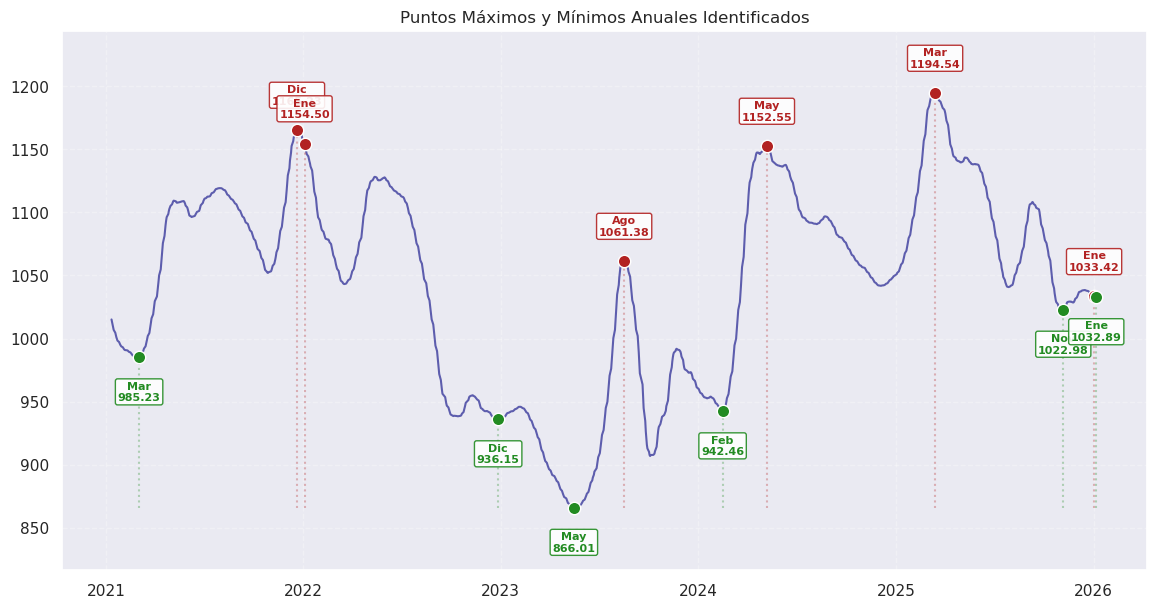

In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. Preparar datos ---
# Aseguramos que el índice y la señal tengan el mismo largo
matched_index = vap.Close.index[-len(rec_signal):]
serie_reconstruida = pd.Series(rec_signal, index=matched_index)

# Diccionario de meses
meses_esp = {
    1: 'Ene', 2: 'Feb', 3: 'Mar', 4: 'Abr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dic'
}

# --- 2. Calcular Puntos Clave ---
# Máximos (Peaks)
fechas_max = serie_reconstruida.groupby(serie_reconstruida.index.year).idxmax()
valores_max = serie_reconstruida.loc[fechas_max]

# Mínimos (Valleys)
fechas_min = serie_reconstruida.groupby(serie_reconstruida.index.year).idxmin()
valores_min = serie_reconstruida.loc[fechas_min]

# --- 3. Graficar ---
fig, ax = plt.subplots(figsize=(14, 7))

# Línea de la señal
ax.plot(matched_index, rec_signal, label='Wavelet Trend', color='navy', alpha=0.6, linewidth=1.5)

# --- FUNCIÓN AUXILIAR PARA DIBUJAR ---
def anotar_puntos(fechas, valores, color, offset_y, tipo):
    for fecha, valor in zip(fechas, valores):
        # 1. Punto
        ax.scatter(fecha, valor, color=color, s=80, zorder=5, edgecolors='white')
        
        # 2. Línea vertical punteada (referencia visual)
        # Si es max, línea hacia abajo. Si es min, línea hacia arriba (opcional, aquí ambas al suelo queda limpio)
        ax.vlines(x=fecha, ymin=min(rec_signal), ymax=valor, 
                  colors=color, linestyles=':', alpha=0.3)

        # 3. Etiqueta (Caja)
        nombre_mes = meses_esp[fecha.month]
        texto = f"{nombre_mes}\n{valor:.2f}"
        
        ax.annotate(texto, 
                    (fecha, valor), 
                    xytext=(0, offset_y), # Aquí controlamos si el texto va arriba o abajo
                    textcoords='offset points', 
                    ha='center', 
                    va='center',
                    fontsize=8, 
                    fontweight='bold', 
                    color=color,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=color, alpha=0.9))

# --- 4. Aplicar la función ---

# Dibujar MÁXIMOS (Rojo, Texto Arriba +25px)
anotar_puntos(fechas_max, valores_max, color='firebrick', offset_y=25, tipo='Max')

# Dibujar MÍNIMOS (Verde, Texto Abajo -25px)
anotar_puntos(fechas_min, valores_min, color='forestgreen', offset_y=-25, tipo='Min')

# Detalles finales
ax.set_title("Puntos Máximos y Mínimos Anuales Identificados")
ax.grid(True, linestyle='--', alpha=0.3)

# Margen extra en Y para que quepan las etiquetas
y_rango = max(rec_signal) - min(rec_signal)
ax.set_ylim(min(rec_signal) - y_rango*0.15, max(rec_signal) + y_rango*0.15)

plt.show()